In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from flows import NormalRW, DFlow, NVPFlow, LogNormal, GVAR, phase,\
Normal, floatX, MVNormal, MVNormalRW, Linear, LinearChol
import flows

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky
import math
from flows.models import VARmodel

np.random.seed(1234)
tf.set_random_seed(1234)

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
tf.trainable_variables()

[]

In [3]:
!ls CDATA

AUS.csv  FRA.csv  GBR.csv  SYNTH.csv


In [4]:
ccodes = ['FRA', 'AUS', 'GBR']
datas = ['./CDATA/{}.csv'.format(x) for x in ccodes]

In [5]:
datas = [pd.read_csv(x, index_col='VARIABLE').iloc[:,:-1] for x in datas]
columns = [data.columns.values.astype('float32') for data in datas]
datas = [data.values.astype(floatX) for data in datas]

In [6]:
[data.shape for data in datas]

[(4, 194), (4, 202), (4, 162)]

In [7]:
max_year = 0

In [8]:
scaler = 0.
for i, data in enumerate(datas):
    stds = (data[:,1:] - data[:,:-1]).std(axis=1)
    print(stds)
    scaler = scaler + stds
    datas[i] = data
print('---')
scaler /= len(datas)
for i in range(len(datas)):
    datas[i] /= scaler[:,np.newaxis]
    data = datas[i]
    stds = (data[:,1:] - data[:,:-1]).std(axis=1)
    print(stds)
    data = np.concatenate([data[:,1:], data[:,:-1]], axis=0)
    data = pd.DataFrame(data, columns=columns[i][1:])
    max_year = max(max_year, max(columns[i][1:]))
    datas[i] = data

[0.00575565 0.9293154  0.00505212 0.03008741]
[0.01346097 1.6949322  0.01075971 0.06685966]
[0.01071561 0.98235863 0.01054417 0.02619566]
---
[0.57686794 0.77301115 0.57506233 0.73298854]
[1.3491448 1.409856  1.2247355 1.6288338]
[1.0739871  0.81713253 1.2002009  0.638178  ]


In [9]:
from flows.models import VARmodel

In [10]:
country_data = {c:d for c,d in zip(ccodes, datas) if c == 'FRA'}

In [11]:
global_inf = DFlow([LinearChol(4*(4*2+1), name='lc')], init_sigma=0.01, num_samples=1024)

global_prior = Normal(shape=None, sigma=1., name='global_prior').logdens(global_inf.output, reduce=False)
global_prior = tf.reduce_sum(global_prior, axis=-1, name='global_prior')
tf.add_to_collection('logdensities', global_inf.logdens)
tf.add_to_collection('priors', global_prior)

<dtype: 'float32'>
<dtype: 'float32'>


In [12]:
for c, d in country_data.items():
    model = VARmodel(d, name='{}_model'.format(c), num_samples=1024,
                      var_dim=4, current_year=2000., mu=global_inf.output[:,tf.newaxis])
    for l in model.logdensities:
        tf.add_to_collection('logdensities', l)
    for p in model.priors:
        tf.add_to_collection('priors', p)

<dtype: 'float32'>
ldiag logdens Tensor("FRA_model/rw_priors/PWalk_inf/flows/sub_1:0", shape=(1024,), dtype=float32)
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
preds Tensor("FRA_model/strided_slice_7:0", shape=(193, 1024, 4), dtype=float32)
Tensor("FRA_model/loglikelihood/strided_slice_2:0", shape=(192, 1024, 4), dtype=float32)
<dtype: 'float32'>


In [13]:
priors = tf.get_collection('priors')
logdensities = tf.get_collection('logdensities')

In [14]:
# priors = priors[:-1]
priors

[<tf.Tensor 'global_prior_2:0' shape=(1024,) dtype=float32>,
 <tf.Tensor 'FRA_model/rw_priors/PWalk_inf/flows/cov_prior/logdens/logdens:0' shape=(1024,) dtype=float32>,
 <tf.Tensor 'FRA_model/PWalk_prior/pwalk_prior:0' shape=(1024,) dtype=float32>,
 <tf.Tensor 'FRA_model/obsrv_prior/LogNormal_1/logdens/logdens:0' shape=(1024,) dtype=float32>,
 <tf.Tensor 'FRA_model/loglikelihood/Sum:0' shape=(1024,) dtype=float32>]

In [15]:
logdensities

[<tf.Tensor 'sub:0' shape=(1024,) dtype=float32>,
 <tf.Tensor 'FRA_model/rw_priors/PWalk_inf/flows/sub_1:0' shape=(1024,) dtype=float32>,
 <tf.Tensor 'FRA_model/coef_rw_inference_1/sample/VAR/logdens/add:0' shape=(1024,) dtype=float32>,
 <tf.Tensor 'FRA_model/obs_d_inf/sub_1:0' shape=(1024,) dtype=float32>]

In [16]:
prior = tf.add_n(priors)
logdensity = tf.add_n(logdensities)
print(prior, logdensity)

kl = logdensity - prior
kl = tf.reduce_mean(kl)
kl /= 36*160

lr = tf.constant(0.002)
def build_upd(lr):
    vs = tf.trainable_variables()
    gs = tf.gradients(kl, vs)
    checks = [tf.check_numerics(x, 'NAN found in {}'.format(x.op.name)) for x in gs if x is not None]
    with tf.control_dependencies(checks):
        main_op = tf.train.AdamOptimizer(lr).apply_gradients(zip(gs,vs))
    return main_op

main_op = build_upd(lr)

Tensor("AddN:0", shape=(1024,), dtype=float32) Tensor("AddN_1:0", shape=(1024,), dtype=float32)


In [17]:
graph = tf.get_default_graph()
rw_prior = graph.get_tensor_by_name('FRA_model/PWalk_prior/pwld_prereduce:0')
tf.summary.scalar('rw_prior', tf.reduce_mean(rw_prior))

<tf.Tensor 'rw_prior:0' shape=() dtype=string>

In [18]:
tf.trainable_variables()

[<tf.Variable 'lc/lowerd:0' shape=(666,) dtype=float32_ref>,
 <tf.Variable 'lc/ldiag:0' shape=(36,) dtype=float32_ref>,
 <tf.Variable 'lc/bias:0' shape=(1, 36) dtype=float32_ref>,
 <tf.Variable 'FRA_model/rw_priors/PWalk_inf/flows/lc/lowerd:0' shape=(666,) dtype=float32_ref>,
 <tf.Variable 'FRA_model/rw_priors/PWalk_inf/flows/lc/ldiag:0' shape=(36,) dtype=float32_ref>,
 <tf.Variable 'FRA_model/rw_priors/PWalk_inf/flows/lc/bias:0' shape=(1, 36) dtype=float32_ref>,
 <tf.Variable 'FRA_model/coef_rw_inference/VAR/precholeskis:0' shape=(193, 36, 36) dtype=float32_ref>,
 <tf.Variable 'FRA_model/coef_rw_inference/VAR/precholeskis_diag:0' shape=(193, 36) dtype=float32_ref>,
 <tf.Variable 'FRA_model/coef_rw_inference/VAR/aux_vars:0' shape=(193, 36, 36) dtype=float32_ref>,
 <tf.Variable 'FRA_model/coef_rw_inference/VAR/mu:0' shape=(193, 1, 36) dtype=float32_ref>,
 <tf.Variable 'FRA_model/obs_d_inf/obs_d_flow/lowerd:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'FRA_model/obs_d_inf/obs_d_flow/

In [19]:
kls = tf.summary.scalar('KLd', kl)
summary = tf.summary.merge_all()

In [20]:
# model.PWalk.diag.eval().mean(axis=0)

In [21]:
# model.PWalk.diag.eval().std(axis=0)

In [22]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

In [23]:
init.run()

In [24]:
# with tf.variable_scope('', reuse=True):
#     gs = tf.get_variable('lc/bias')
# gs = tf.gradients(kl, [gs])[0]

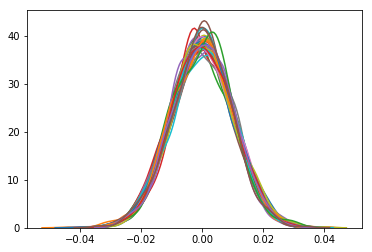

In [25]:
ginf_outputs = global_inf.output.eval()
for i in range(ginf_outputs.shape[1]):
    sns.kdeplot(ginf_outputs[:,i])
plt.show()

In [26]:
output = model.outputs.eval()

In [27]:
output.dtype

dtype('float32')

In [28]:
model.PWalk.diag.eval().mean(axis=0)

array([0.00250037, 0.00250059, 0.00249976, 0.00250091, 0.00250054,
       0.00250021, 0.00249934, 0.00250086, 0.00249846, 0.00249873,
       0.00250125, 0.00249917, 0.00250073, 0.00249932, 0.00250082,
       0.00250012, 0.00250085, 0.00250069, 0.00250021, 0.00250072,
       0.00249969, 0.00250032, 0.00249955, 0.00249986, 0.00250061,
       0.00249865, 0.00250053, 0.00249966, 0.0025012 , 0.00250078,
       0.00249986, 0.00250035, 0.00250061, 0.00250058, 0.0025003 ,
       0.0024995 ], dtype=float32)

In [33]:
writer = tf.summary.FileWriter('/home/nikita/tmp/tfdbg/single')

In [30]:
epoch = 0

In [31]:
epoch

0

In [35]:
for epoch in range(epoch, 100000):
    print(epoch)
    for step in range(20):
        sess.run(main_op)
    s, _ = sess.run([summary, main_op], {lr: 0.002})
    writer.add_summary(s, global_step=epoch)

54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


KeyboardInterrupt: 

In [42]:
preds = model.preds.eval().mean(axis=1)[:50]

In [53]:
true = model.data.eval()[0,:,:4][1:51]

In [54]:
preds.shape

(50, 4)

In [55]:
true.shape

(50, 4)

In [56]:
np.std(preds[:-1]-true[1:], axis=0)

array([0.81533504, 1.1036178 , 0.86292905, 0.9688889 ], dtype=float32)

In [ ]:
outputs.shape

In [36]:
sum_feed, diffs, premu = map(lambda x: graph.get_tensor_by_name(x), ['FRA_model/PWalk_prior/sum_feeder:0', 
                                                       'FRA_model/PWalk_prior/diffs:0', 'FRA_model/PWalk_prior/premu:0'])
sum_feed, diffs, premu = sess.run([sum_feed, diffs, premu])

In [37]:
sum_feed

8.645064781491961e-05

In [38]:
np.mean(np.std(diffs, axis=1))

8.645065e-05

In [48]:
target = np.concatenate([np.zeros_like(premu[:,0:1]), premu[:,:-1]], axis=1)
devs = target - premu

In [49]:
np.mean(np.std(devs, axis=1))

0.0014097176

In [47]:
devs

array([[[ 3.89819685e-03,  1.89049193e-03,  4.06879408e-04, ...,
         -1.35858159e-03,  1.94989610e-03,  8.99460050e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 2.10420322e-03, -1.42563600e-04,  1.70670974e-03, ...,
          2.92650075e-05,  5.91191871e-04, -1.01388013e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

In [34]:
premu = graph.get_tensor_by_name('FRA_model/PWalk_prior/premu:0').eval()
outputs = premu
#outputs = model.outputs.eval()
devs = outputs[:,1:] - outputs[:,:-1]
# devs = np.reshape(devs, (-1,36))

In [35]:
np.std(devs, axis=1).mean(axis=0)

array([0.03369256, 0.06192776, 0.04239453, 0.05740929, 0.02779159,
       0.05932825, 0.0454927 , 0.0576301 , 0.03170228, 0.03568772,
       0.05864771, 0.05371627, 0.07833118, 0.03455689, 0.03780512,
       0.07813829, 0.06560326, 0.03477513, 0.02593875, 0.06073683,
       0.0276897 , 0.04212036, 0.02430456, 0.05834348, 0.03530106,
       0.03327612, 0.02201895, 0.01826524, 0.05192674, 0.02525268,
       0.03494739, 0.01876917, 0.04510746, 0.02683005, 0.04424054,
       0.01427648], dtype=float32)

In [ ]:
premu.shape

In [ ]:
outputs.shape

In [ ]:
saver = tf.train.Saver()

In [ ]:
saver.save(sess, '/tmp/debug_save')

In [ ]:
graph = tf.get_default_graph()

In [ ]:
[x for x in graph.get_operations() if 'walk_distr' in x.name]

In [ ]:
writer.add_graph(graph)

In [ ]:
premu = graph.get_tensor_by_name('FRA_model/PWalk_prior/premu:0').eval()

In [ ]:
for i in range(5):
    sns.kdeplot(output[:,2,i], output[:,5,i])
    plt.show()

In [ ]:
tf.trainable_variables()

In [ ]:
graph.get_tensor_by_name('FRA_model/coef_rw_inference/VAR/mu:0').eval()

In [ ]:
preds = model.preds.eval().mean(axis=1)

In [ ]:
dd = model.data_raw.values[:4,:].T

In [ ]:
np.std(preds - dd, axis=0)

In [ ]:
graph = tf.get_default_graph()

In [ ]:
graph.get_tensor_by_name('FRA_model/PWalk_prior/pwalk_prior_ld:0').eval()

In [ ]:
kl.eval()

In [ ]:
diags = []
for _ in range(4000):
    d = model.PWalk.diag.eval().mean(axis=0)
    diags.append(d)
diags = np.mean(diags, axis=0)

In [ ]:
diags

In [ ]:
wsigmas = tf.sqrt(tf.diag_part(model.PWalk.sigma))

In [ ]:
wsigmas

In [ ]:
global_post=global_inf.output[0]

In [ ]:
ss = []
for _ in range(1000):
    ss.append(wsigmas.eval())
ss = np.array(ss)

In [ ]:
np.mean(ss,axis=0)

In [ ]:
ss.std(axis=0)

In [ ]:
sns.kdeplot(ss[:,4], ss[:,1])
plt.show()